# Spotify elemzésem – 8 alap lépés + 5 extra lekérdezés (összesen 13)

Ez az én egyszerű, átlátható notebookom. Lépésről lépésre haladok:

1) Könyvtárak betöltése
2) Adatok beolvasása (JSON fájlok egyesítése)
3) Minimális előkészítés (dátum, perc, egyszerű címkék)

Lekérdezések:

4) Összes hallgatási idő év/hónap szerint

5) Top 10 előadó (perc) és Top 10 dal (lejátszásszám)

6) Időbeli szokások: hét napja × óra pivot + offline/online arány

7) Platform-megoszlás (összes perc és részesedés %)

8) Top 10 nap – legtöbb hallgatott perc + aktív napok száma

9) Havi előadói diverzitás – egyedi előadók száma hónaponként

10) Hosszú lejátszások aránya (≥ 2 perc) – összesen és havi bontásban

11) Óránkénti megoszlás – melyik órákban hallgatok legtöbbet

12) Napok szerinti megoszlás – melyik hétköznapokon hallgatok legtöbbet

13) Átugrási ráta előadónként (mintaszűrés mellett)


In [140]:
# 1) Könyvtárak
import json  # JSON fájlok beolvasásához
from pathlib import Path  # Platformfüggetlen fájl-/útvonalkezeléshez
import numpy as np  # Numerikus műveletekhez (NaN, százalékok, stb.)
import pandas as pd  # Adatkezeléshez és -elemzéshez (DataFrame)
from IPython.display import display  # Táblázatok szép megjelenítéséhez notebookban
import matplotlib.pyplot as plt  # Diagramokhoz
import seaborn as sns  # Stílusosabb diagramokhoz

# Szebb táblázat-kimenet (pandas megjelenítési beállítások)
pd.set_option('display.max_rows', 50)  # Max. megjelenített sorok száma
pd.set_option('display.max_columns', 50)  # Max. megjelenített oszlopok száma
pd.set_option('display.width', 120)  # Kimenet szélessége karakterben

In [141]:
# 2) Adatok beolvasása (egy mappából több JSON egyesítése)
DATA_DIR = Path.cwd() / 'Spotify_Extended_Streaming_History'  # Spotify adatok mappája (állítsd át, ha máshol van)
AUDIO_PAT = 'Streaming_History_Audio_*.json'  # Audio JSON fájlok mintája
VIDEO_PAT = 'Streaming_History_Video_*.json'  # Video JSON fájlok mintája (opcionális)

def read_json_list(p: Path) -> list:
    with p.open('r', encoding='utf-8') as f:  # Fájl megnyitása olvasásra, UTF-8 kódolással
        return json.load(f)  # JSON betöltése (listát várunk)

rows = []  # Ide gyűjtöm az összes rekordot minden fájlból
for p in sorted(DATA_DIR.glob(AUDIO_PAT)):  # Audio fájlok bejárása, név szerint rendezve
    try:
        rows.extend(read_json_list(p))  # A fájlban lévő listát hozzáfűzöm a gyűjtőlistához
    except Exception as e:
        print(f'Hiba audio fájl olvasásakor: {p.name} -> {e}')  # Hiba esetén fájlnév + hiba kiírása
for p in sorted(DATA_DIR.glob(VIDEO_PAT)):  # Video fájlok bejárása, név szerint rendezve
    try:
        rows.extend(read_json_list(p))  # Hozzáfűzöm a videós rekordokat is (ha vannak)
    except Exception as e:
        print(f'Hiba video fájl olvasásakor: {p.name} -> {e}')  # Hiba esetén logolás

df = pd.DataFrame(rows)  # Az összes rekordot táblába teszem (további elemzéshez)
display(df.head(1))  # Minta: első 1 sor megjelenítése ellenőrzésképp

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,audiobook_title,audiobook_uri,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2018-07-30T15:39:56Z,"Android OS 5.1 API 22 (LENOVO, Lenovo A7010a48)",11648,HU,176.63.30.118,None,None,None,None,#0 - Pilot,The Misfits Podcast,spotify:episode:67vcPiq854ZJhZUjEobsL0,None,None,None,None,clickrow,unexpected-exit-while-paused,False,False,False,NaN,False


In [142]:
# 3) Minimális előkészítés
df = df.copy()  # Másolat készítése, hogy az eredeti DataFrame érintetlen maradjon
df['ts'] = pd.to_datetime(df.get('ts'), utc=True, errors='coerce')  # type: ignore # Időbélyeg datetime-á alakítása UTC-ben; hibás érték -> NaT
df = df.dropna(subset=['ts'])  # Hibás/Nem értelmezhető időbélyegek eldobása

df['sec'] = (df.get('ms_played').fillna(0) / 1000).astype(float)   # type: ignore  # Ezredmásodperc -> másodperc; hiányzó értékek 0-ra töltése
df = df[df['sec'] >= 0]  # Negatív időtartamok kiszűrése (adattisztítás)
df['min'] = df['sec'] / 60.0  # Másodperc -> perc (könnyebb aggregálni)

df['artist'] = df.get('master_metadata_album_artist_name')  # Előadó neve kényelmi oszlopba
df['track']  = df.get('master_metadata_track_name')  # Dal címe kényelmi oszlopba

df['date']  = df['ts'].dt.date  # Csak a dátum része (YYYY-MM-DD)
df['year']  = df['ts'].dt.year  # Év (YYYY)
df['month'] = df['ts'].dt.tz_localize(None).dt.to_period('M').astype(str)  # Hónap (YYYY-MM)
df['hour']  = df['ts'].dt.hour  # Óra (0..23)
df['dow']   = df['ts'].dt.dayofweek  # Hét napja (0=hétfő .. 6=vasárnap)

def simplify_platform(s: str) -> str:  # Platformok egyszerűsítése közös kategóriákra
    if not isinstance(s, str):  # Ha nem szöveg (NaN, None, stb.)
        return 'Other'  # Egyéb kategória
    s = s.lower()  # Kisbetűsítés az összehasonlításhoz
    if 'android' in s: return 'Android'  # Android eszköz
    if 'ios' in s or 'iphone' in s or 'ipad' in s: return 'iOS'  # Apple mobil eszköz
    if 'windows' in s: return 'Windows'  # Windows asztali/kliens
    if 'mac os' in s or 'macos' in s or 'os x' in s: return 'Mac'  # macOS/OS X
    if 'linux' in s: return 'Linux'  # Linux
    return 'Other'  # Egyéb (nem azonosított)

df['platform_simple'] = df.get('platform').apply(simplify_platform)  # Egyszerűsített platform hozzárendelése
df['offline'] = df.get('offline', False).fillna(False).astype(bool)  # Offline jelző normalizálása logikaivá
df['skipped'] = df.get('skipped', False).fillna(False).astype(bool)  # Átugrás jelző normalizálása logikaivá


print(df.shape)  # DataFrame mérete (sor, oszlop)
display(df[['ts','artist','track','min','platform_simple','offline']].head(5))  # Ellenőrző minta megjelenítése

(134514, 33)


C:\Users\gondo\AppData\Local\Temp\ipykernel_8828\608557690.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['offline'] = df.get('offline', False).fillna(False).astype(bool)  # Offline jelző normalizálása logikaivá


,ts,artist,track,min,platform_simple,offline
0,2018-07-30 15:39:56+00:00,None,None,0.194133,Android,False
1,2018-07-31 11:57:58+00:00,None,None,0.844417,Android,False
2,2018-07-31 13:18:15+00:00,None,None,18.892517,Android,False
3,2018-07-31 15:39:00+00:00,None,None,18.892517,Android,False
4,2018-08-01 10:33:50+00:00,None,None,2.998250,Android,False


Éves összesítés:


,year,Összes perc az évben
0,2018,343.7
1,2019,317.9
2,2020,1202.4
3,2021,8397.5
4,2022,37913.3
5,2023,49643.0
6,2024,72056.1
7,2025,50972.2


Havi összesítés (időrendi):


,month,Összes perc/hó
51,2024-10,5201.7
52,2024-11,4466.1
53,2024-12,5082.0
54,2025-01,3799.1
55,2025-02,5968.9
56,2025-03,4882.5
57,2025-04,5135.2
58,2025-05,4262.9
59,2025-06,7919.2
60,2025-07,8519.2


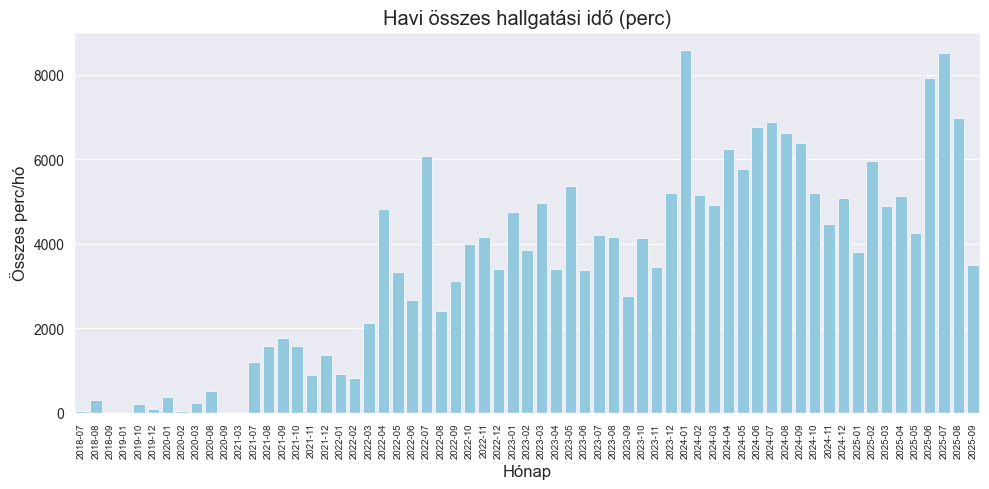

In [143]:
# 4) Összes hallgatási idő – év és hónap szerint
ev = (
    df.groupby('year')['min'].sum()  # Év szerinti csoportosítás, percek összeadása
    .reset_index()  # Visszaalakítás táblává (index -> oszlop)
    .rename(columns={'min': 'Összes perc az évben'})  # Beszédes oszlopnév
    .round(1)  # Kerekítés 1 tizedesre
)

honap = (
    df.groupby('month')['min'].sum()  # Hónap szerinti csoportosítás, percek összeadása
    .reset_index()  # Táblává alakítás
    .rename(columns={'min': 'Összes perc/hó'})  # Beszédes oszlopnév
    .sort_values('month')  # Időrendi rendezés (YYYY-MM)
    .round(1)  # Kerekítés 1 tizedesre
)

print('Éves összesítés:')
display(ev)  # Éves összes percek táblázata

print('Havi összesítés (időrendi):')
display(honap.tail(12))  # Utolsó 12 hónap (friss időszak fókusz)

# Ritkn látott diagram
plt.figure(figsize=(10,5))  # Ábra létrehozása adott méretben
sns.barplot(data=honap, x='month', y='Összes perc/hó', color='skyblue')  # Oszlopdiagram Seaborn-nal
# nagyobb rés az x tengelyen
plt.tick_params(axis='x', labelsize=7)  # X tengely feliratok mérete
plt.xticks(rotation=90)  # X tengely feliratok forgatása
plt.title('Havi összes hallgatási idő (perc)')  # Cím
plt.xlabel('Hónap')  # X tengely felirat
plt.ylabel('Összes perc/hó')  # Y tengely felirat
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

,artist,Összes perc
719,Eminem,22989.2
1554,NF,18776.3
1878,Ryan Caraveo,8406.3
2493,mgk,7741.6
1145,Kanye West,5908.0
1164,Kendrick Lamar,5584.4
1103,Joyner Lucas,5318.7
2338,Witt Lowry,4330.7
1226,Krúbi,3917.0
306,Beton.Hofi,3866.8


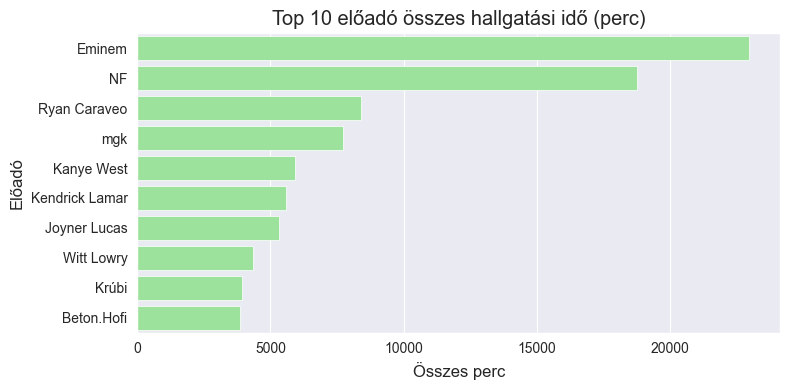

,artist,track,Lejátszások száma
2353,Eminem,Lucky You (feat. Joyner Lucas),382
2439,Eminem,Till I Collapse,360
7568,XXXTENTACION,SAD!,336
5244,NF,Nate,306
5203,NF,DRIFTING,305
5232,NF,Let You Down,298
2061,EDEN,Wake Up,292
5260,NF,Remember This,286
2372,Eminem,No Regrets (feat. Don Toliver),278
6199,Ryan Caraveo,From Hell With Love,274


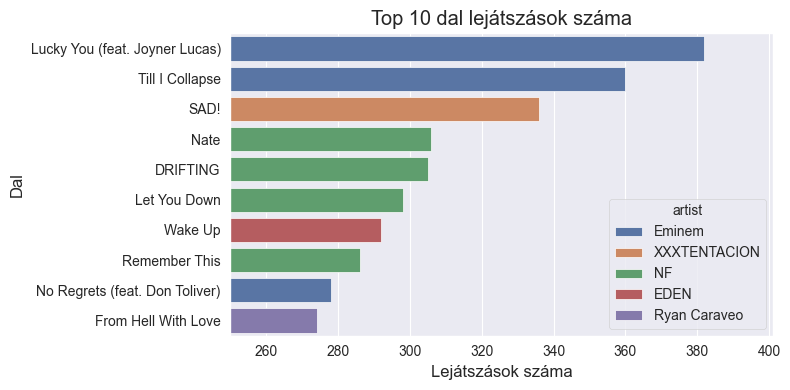

In [144]:
# 5/a) Top 10 előadó (összes perc alapján)
top_artists = (
    df.dropna(subset=['artist'])  # Hiányzó előadónevek eldobása
    
    .groupby('artist')['min'].sum()  # Előadónként percek összege
    
    .reset_index()  # Táblává alakítás (index -> oszlop)

    .rename(columns={'min': 'Összes perc'})  # Új oszlopnév

    .sort_values('Összes perc', ascending=False)  # Csökkenő sorrend
    
    .head(10)  # Top 10
    
    .round({'Összes perc': 1})  # Kerekítés 1 tizedesre
)
display(top_artists)  # Top 10 előadó percekkel

#diagram 
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=top_artists, x='Összes perc', y='artist', color='lightgreen')  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Top 10 előadó összes hallgatási idő (perc)')  # Cím
plt.xlabel('Összes perc')  # X tengely felirat
plt.ylabel('Előadó')  # Y tengely felirat
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

# 5/b) Top 10 dal (lejátszások száma alapján)
top_tracks = (
    df.dropna(subset=['artist','track'])  # Hiányzó előadó/dal sorok eldobása
    
    .groupby(['artist','track']).size()  # Előadó–dal páronként előfordulásszám
    
    .reset_index(name='Lejátszások száma')  # Számláló oszlop elnevezése
    
    .sort_values('Lejátszások száma', ascending=False)  # Csökkenő sorrend
    
    .head(10)  # Top 10 dal
)
display(top_tracks)  # Top 10 dal az indítások számával

# diagram, x tengely 200-tól kezdődjön

plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=top_tracks, x='Lejátszások száma', y='track', hue='artist', dodge=False)  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Top 10 dal lejátszások száma')  # Cím
plt.xlabel('Lejátszások száma')  # X tengely felirat
plt.ylabel('Dal')  # Y tengely felirat
plt.xlim(left=250)  # X tengely korlátozása
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

,platform_simple,Összes perc,Részesedés (%)
2,Windows,142936.6,64.72
0,Android,77802.6,35.23
1,Other,106.9,0.05


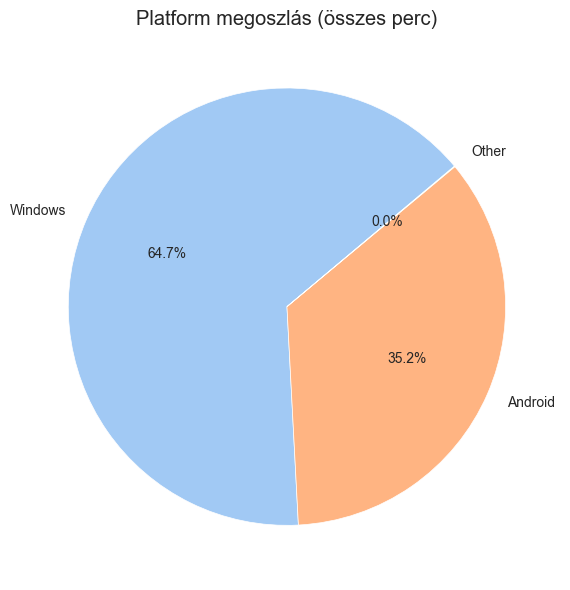

In [145]:
# 7) Platform-megoszlás – összes perc és részesedés (%)
plat = (
    df.groupby('platform_simple')['min'].sum().reset_index()  # Platformonként percek összege + táblává alakítás
    .rename(columns={'min': 'Összes perc'})  # Beszédes oszlopnév
    .sort_values('Összes perc', ascending=False)  # Csökkenő sorrend
)

osszes = plat['Összes perc'].sum()  # Teljes perc (nevező)

plat['Részesedés (%)'] = (
    100 * plat['Összes perc'] / (osszes if osszes else np.nan)  # Százalékos részesedés (0 osztás védve)
)

display(plat.round({'Összes perc': 1, 'Részesedés (%)': 2}))  # Kerekítés + megjelenítés

# kördiagram
plt.figure(figsize=(6,6))  # Ábra létrehozása adott méretben
plt.pie(plat['Összes perc'], labels=plat['platform_simple'], autopct='%1.1f%%', startangle=40, colors=sns.color_palette('pastel'))  # Kördiagram
plt.title('Platform megoszlás (összes perc)')  # Cím
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése    

Top 10 nap (legtöbb hallgatott perc):


,date,Összes perc
1094,2024-08-05,878.5
893,2024-01-17,621.4
894,2024-01-18,564.3
1419,2025-06-29,561.8
1101,2024-08-12,557.7
547,2023-01-29,553.3
1028,2024-05-31,548.0
1413,2025-06-23,547.4
896,2024-01-20,524.1
1451,2025-07-31,509.2


Text(0, 0.5, 'Dátum')

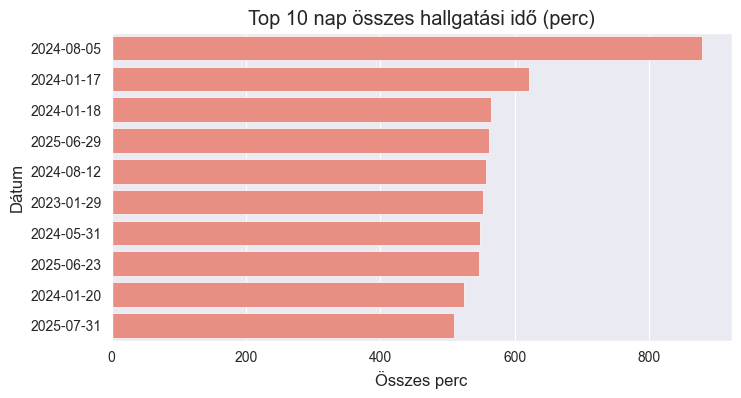

In [146]:
# 8) Top 10 nap – legtöbb hallgatott perc + aktív napok száma
napok = (
    df.groupby('date')['min'].sum().reset_index()  # Naponként percek összege + táblává alakítás
    .rename(columns={'min': 'Összes perc'})  # Beszédes oszlopnév
    .sort_values('Összes perc', ascending=False)  # Csökkenő sorrend (legerősebb napok felül)
)

print('Top 10 nap (legtöbb hallgatott perc):')
display(
    napok.head(10).round({'Összes perc': 1})  # Top 10 nap kerekítve
)

# diagram
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=napok.head(10), x='Összes perc', y='date', color='salmon')  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Top 10 nap összes hallgatási idő (perc)')  # Cím
plt.xlabel('Összes perc')  # X tengely felirat
plt.ylabel('Dátum')  # Y tengely felirat


In [147]:
# Aktív napok száma
aktiv_napok = napok['date'].nunique()  # Egyedi napok száma (aktív napok)
print(f'Összes aktív nap száma: {aktiv_napok:,}')  # Aktív napok száma formázva


Összes aktív nap száma: 1,504


,month,Egyedi előadók száma
46,2024-10,258
47,2024-11,272
48,2024-12,377
49,2025-01,233
50,2025-02,229
51,2025-03,226
52,2025-04,286
53,2025-05,369
54,2025-06,502
55,2025-07,383


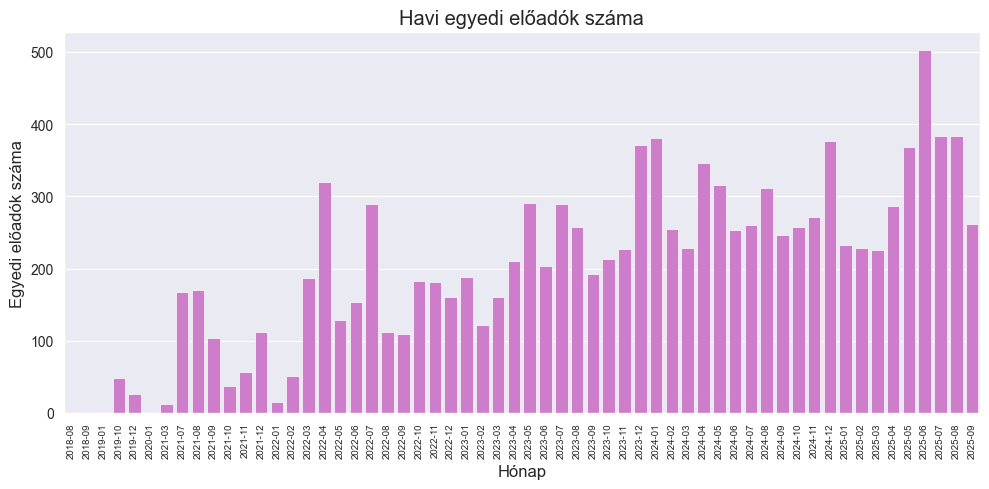

In [148]:
# 9) Havi előadói diverzitás – egyedi előadók száma hónaponként
div = (
    df.dropna(subset=['artist'])  # Hiányzó előadónév eldobása
    .groupby('month')['artist'].nunique()  # Hónaponként egyedi előadók száma
    .reset_index(name='Egyedi előadók száma')  # Táblává alakítás és oszlopnév
    .sort_values('month')  # Időrendi rendezés
)

display(div.tail(12))  # Utolsó 12 hónap megjelenítése

# diagram
plt.figure(figsize=(10,5))  # Ábra létrehozása adott méretben
sns.barplot(data=div, x='month', y='Egyedi előadók száma', color='orchid')  # Oszlopdiagram Seaborn-nal
plt.tick_params(axis='x', labelsize=7)  # X tengely feliratok mérete
plt.xticks(rotation=90)  # X tengely feliratok forgatása
plt.title('Havi egyedi előadók száma')  # Cím
plt.xlabel('Hónap')  # X tengely felirat
plt.ylabel('Egyedi előadók száma')  # Y tengely felirat
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

Összes hosszú lejátszás aránya (≥ 2.0 perc): 41.5%


C:\Users\gondo\AppData\Local\Temp\ipykernel_8828\259016478.py:19: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  _tmp.assign(Ev_es_honap=_tmp['ts'].dt.to_period('M').astype(str))  # YYYY-MM kulcs


,Ev_es_honap,lejatszas_db,hosszu_db,hosszu_szazalek
51,2024-10,3161,1304,41.3
52,2024-11,3533,1103,31.2
53,2024-12,4586,1258,27.4
54,2025-01,3134,929,29.6
55,2025-02,3254,1524,46.8
56,2025-03,2957,1231,41.6
57,2025-04,2943,1285,43.7
58,2025-05,3911,1074,27.5
59,2025-06,4939,2062,41.7
60,2025-07,5124,2184,42.6


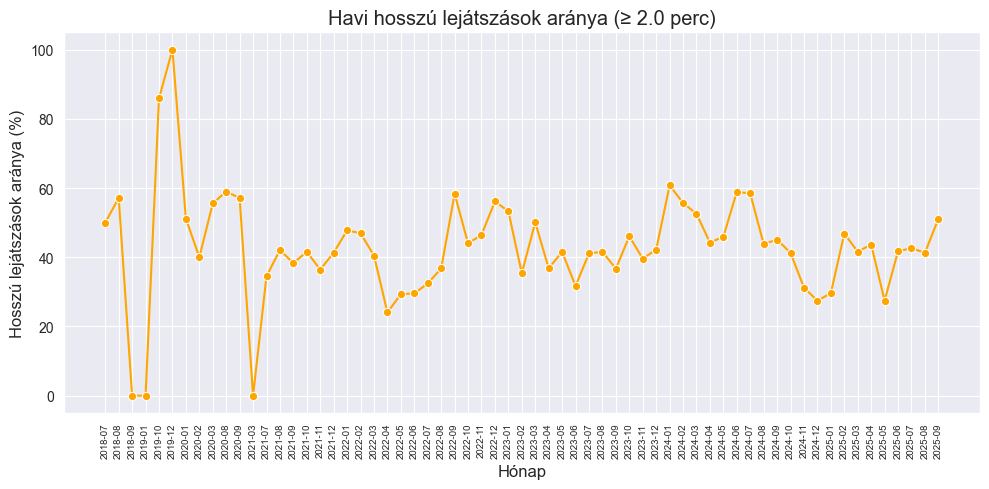

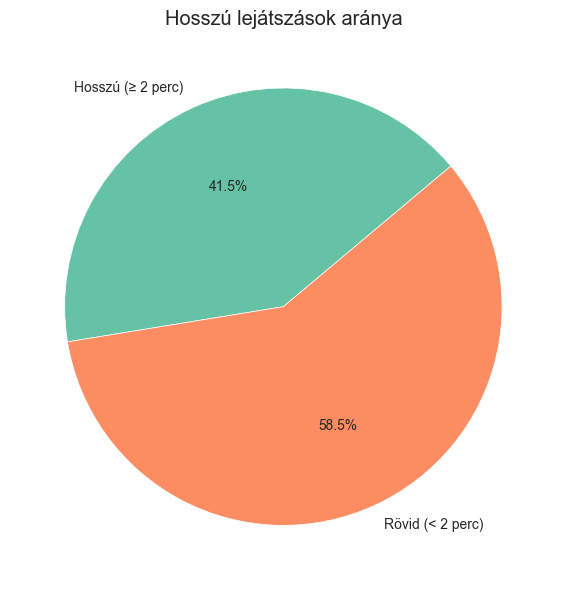

In [149]:
# 10) Hosszú lejátszások aránya (≥ 2 perc) – összesen és havi bontásban
kuszob_perc = 2.0  # Hosszú lejátszás küszöbe percben

_tmp = df.assign(  # Ideiglenes DF hosszú-jelzővel
    hosszu=lambda x: x['min'] >= kuszob_perc  # True, ha eléri a küszöböt
)

lejatszas_db = int(len(_tmp))  # Összes lejátszás száma (sorok száma)
hosszu_db = int(_tmp['hosszu'].sum())  # Hosszú lejátszások száma (True értékek összege)

ossz_arany = (
    100 * hosszu_db / lejatszas_db if lejatszas_db else np.nan  # Összes arány % (0 osztás védve)
)
print(
    f'Összes hosszú lejátszás aránya (≥ {kuszob_perc} perc): {ossz_arany:.1f}%'
)

havi = (
    _tmp.assign(Ev_es_honap=_tmp['ts'].dt.to_period('M').astype(str))  # YYYY-MM kulcs
    .groupby('Ev_es_honap')  # Hónaponkénti csoportosítás
    .agg(  # Named aggregation: több metrika egyszerre
        lejatszas_db=('hosszu','size'),  # Mintaszám
        hosszu_db=('hosszu','sum'),     # Hosszú darabszám
    )
    .assign(
        hosszu_szazalek=lambda t: 100 * t['hosszu_db'] / t['lejatszas_db']  # Havi %
    )
    .reset_index()  # Táblává alakítás
    .sort_values('Ev_es_honap')  # Időrendi rendezés
)

display(havi.tail(12).round({'hosszu_szazalek': 1}))  # Utolsó 12 hónap megjelenítése

# diagram
plt.figure(figsize=(10,5))  # Ábra létrehozása adott méretben
sns.lineplot(data=havi, x='Ev_es_honap', y='hosszu_szazalek', marker='o', color='orange')  # Vonaldiagram Seaborn-nal
plt.tick_params(axis='x', labelsize=7)  # X tengely feliratok mérete
plt.xticks(rotation=90)  # X tengely feliratok forgatása
plt.title(f'Havi hosszú lejátszások aránya (≥ {kuszob_perc} perc)')  # Cím
plt.xlabel('Hónap')  # X tengely felirat
plt.ylabel('Hosszú lejátszások aránya (%)')  # Y tengely felirat
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

# Hosszú lajátszások aránya (≥ 2 perc) kördiagrammon

long_plays = pd.DataFrame({
    'Típus': ['Hosszú (≥ 2 perc)', 'Rövid (< 2 perc)'],
    'Darabszám': [hosszu_db, lejatszas_db - hosszu_db]
})
plt.figure(figsize=(6,6))  # Ábra létrehozása adott méretben
plt.pie(long_plays['Darabszám'], labels=long_plays['Típus'].tolist(), autopct='%1.1f%%', startangle=40, colors=sns.color_palette('Set2'))
plt.title('Hosszú lejátszások aránya')  # Cím
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése    

Óránkénti megoszlás (0..23):


,hour,Összes perc
0,0,10719.65
1,1,8506.66
2,2,5344.09
3,3,2422.94
4,4,1011.95
5,5,1877.17
6,6,2309.65
7,7,2534.52
8,8,3701.61
9,9,5535.66


Top 5 óra a legtöbb perccel:


,hour,Összes perc
17,17,14841.7
16,16,14170.8
13,13,13542.9
15,15,13500.8
14,14,13416.0


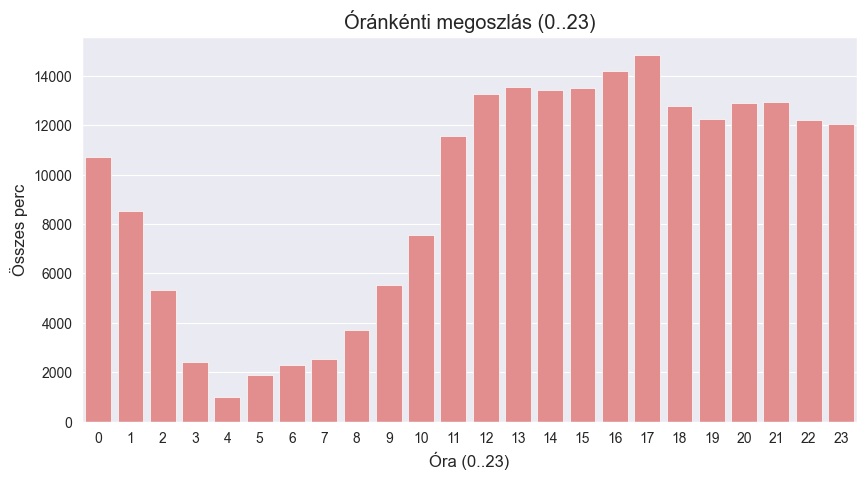

In [ ]:
# 11) Óránkénti megoszlás – "melyik órákban hallgatsz legtöbbet"
ora = (
    df.groupby('hour')['min'].sum().reset_index()  # Óránként percek összege + táblává alakítás
    .rename(columns={'min':'Összes perc'}).round(2)  # Beszédes oszlopnév
)

ora = ora.sort_values('hour')  # Időrendi rendezés (0..23)

print('Óránkénti megoszlás (0..23):') 
display(ora)  # Teljes táblázat

print('Top 5 óra a legtöbb perccel:') 
display(
    ora.sort_values('Összes perc', ascending=False)
       .head(5)  # Top 5 óra
       .round({'Összes perc':1})  # Kerekítés 1 tizedesre
)

#diagram
plt.figure(figsize=(10,5))  # Ábra létrehozása adott méretben
sns.barplot(data=ora, x='hour', y='Összes perc', color='lightcoral')  # Oszlopdiagram Seaborn-nal
plt.title('Óránkénti megoszlás (0..23)')  # Cím     
plt.xlabel('Óra (0..23)')  # X tengely felirat
plt.ylabel('Összes perc')  # Y tengely felirat
plt.show()  # Ábra megjelenítése

,Nap,Összes perc
0,Hétfő,35123.045700
1,Kedd,28982.355683
2,Szerda,31394.055383
3,Csütörtök,31687.185217
4,Péntek,35217.164167
5,Szombat,29799.511967
6,Vasárnap,28642.823433


Top 3 nap:


,Nap,Összes perc
4,Péntek,35217.2
0,Hétfő,35123.0
3,Csütörtök,31687.2


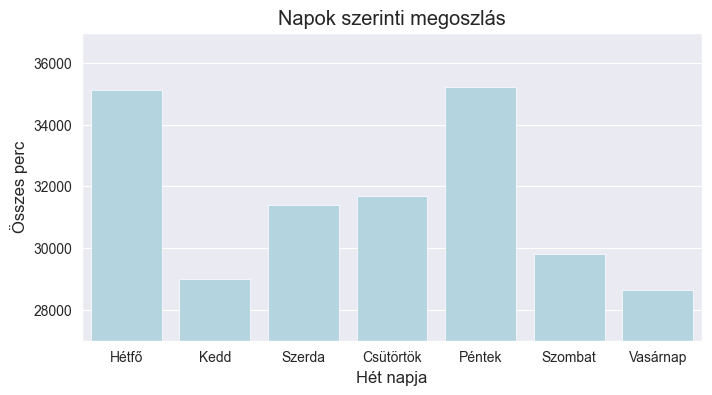

In [ ]:
# 12) Napok szerinti megoszlás – "hét mely napjain hallgatsz legtöbbet"
nap = (
    df.groupby('dow')['min'].sum().reset_index()  # Hét napja szerint percek összege + táblává alakítás
    .rename(columns={'min':'Összes perc'})  # Beszédes oszlopnév
)

nap = nap.sort_values('dow')  # Hétfőtől vasárnapig

nap['Nap'] = nap['dow'].map({  # Magyar napnevek
    0:'Hétfő', 1:'Kedd', 2:'Szerda', 3:'Csütörtök', 4:'Péntek', 5:'Szombat', 6:'Vasárnap'
})

nap = nap[['Nap','Összes perc']]  # Tiszta táblázat (csak felirat és érték)

display(nap)  # Megjelenítés

print('Top 3 nap:')  # Top napok
display(
    nap.sort_values('Összes perc', ascending=False) # Csökkenő sorrend
       .head(3)
       .round({'Összes perc':1})  # Top 3 nap kerekítve
)

#diagram
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=nap, x='Nap', y='Összes perc', color='lightblue')  # Oszlopdiagram Seaborn-nal
plt.title('Napok szerinti megoszlás')  # Cím
plt.ylim(27000)  # Y tengely 0-tól kicsit a max fölé
plt.xlabel('Hét napja')  # X tengely felirat
plt.ylabel('Összes perc')  # Y tengely felirat
plt.show()  # Ábra megjelenítése

Legmagasabb átugrási ráta – top 10:


,artist,minta,kihagyas,perc,Átugrási ráta (%)
77,AWS,282,214,375.5,75.89
1290,Lil Frakk,294,222,338.8,75.51
1226,Krúbi,2037,1462,3917.0,71.77
230,BEATó,442,311,456.3,70.36
675,Dé:Nash,306,214,533.5,69.93
797,Frank Ocean,248,173,323.2,69.76
1535,Munn,175,118,231.3,67.43
469,Chris Brown,191,127,237.4,66.49
808,Future,176,115,197.7,65.34
30,50 Cent,566,368,781.4,65.02



Legalacsonyabb átugrási ráta – top 10:


,artist,minta,kihagyas,perc,Átugrási ráta (%)
1997,Skylar Grey,272,62,640.0,22.79
336,Bo Burnham,815,209,1728.2,25.64
1308,Lilly Wood and The Prick,236,70,292.0,29.66
690,Ed Sheeran,522,177,689.9,33.91
1665,OneRepublic,211,73,377.6,34.60
816,GAYLE,210,73,257.6,34.76
1742,Polo G,719,251,1150.1,34.91
1009,James Arthur,292,107,617.4,36.64
2200,Tom Odell,254,99,420.8,38.98
714,Emcee KB,622,243,1234.0,39.07


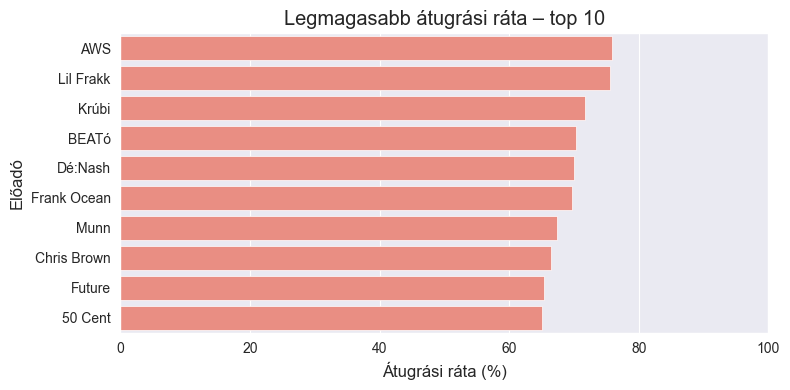

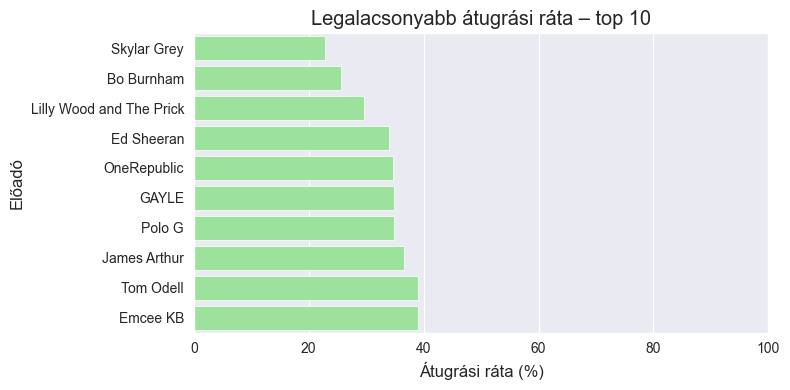

In [152]:
# 13) Átugrási ráta előadónként (mintaszűrés mellett)
sk = df.copy()  # Másolat készítése

sk['skipped'] = (
    sk.get('skipped', False).fillna(False).astype(bool)  # Átugrás jelző normalizálása logikaivá (NaN->False)
)

stats = (
    sk.dropna(subset=['artist'])  # Hiányzó előadónevek eldobása
    .groupby('artist')  # Előadónkénti csoportosítás
    .agg(  # Named aggregation
        minta=('skipped','size'),   # Mintaszám
        kihagyas=('skipped','sum'), # Átugrások száma
        perc=('min','sum'),         # Összes perc
    )
    .reset_index()  # Táblává alakítás
)

stats = stats[stats['minta'] >= 175].copy()  # Mintaküszöb (stabilabb arány)

stats['Átugrási ráta (%)'] = (
    100 * stats['kihagyas'] / stats['minta']  # Százalékos ráta számítása
)

print('Legmagasabb átugrási ráta – top 10:')
display(
    stats.sort_values('Átugrási ráta (%)', ascending=False)
         .head(10)
         .round({'Átugrási ráta (%)':2, 'perc':1})  # Top 10 magas ráta
)

print('\nLegalacsonyabb átugrási ráta – top 10:')
display(
    stats.sort_values('Átugrási ráta (%)', ascending=True)
         .head(10)
         .round({'Átugrási ráta (%)':2, 'perc':1})  # Top 10 alacsony ráta
)

# diagram – legmagasabb 10
top_sk = (
    stats.sort_values('Átugrási ráta (%)', ascending=False)
         .head(10)
)
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=top_sk, x='Átugrási ráta (%)', y='artist', color='salmon')  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Legmagasabb átugrási ráta – top 10')  # Cím
plt.xlabel('Átugrási ráta (%)')  # X tengely felirat
plt.ylabel('Előadó')  # Y tengely felirat
plt.xlim(0,100)  # X tengely 0..100%
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

# legalacsonyabb 10
low_sk = (
    stats.sort_values('Átugrási ráta (%)', ascending=True)
         .head(10)
)
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=low_sk, x='Átugrási ráta (%)', y='artist', color='lightgreen')  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Legalacsonyabb átugrási ráta – top 10')  # Cím
plt.xlabel('Átugrási ráta (%)')  # X tengely felirat
plt.ylabel('Előadó')  # Y tengely felirat
plt.xlim(0,100)  # X tengely 0..100%
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

Legtöbbet hallgatott előadók átugrási rátája (top 10):


,artist,minta,kihagyas,Átugrási ráta (%),perc
719,Eminem,13012,6109,46.95,22989.2
1554,NF,11305,4590,40.60,18776.3
1878,Ryan Caraveo,4489,2125,47.34,8406.3
2493,mgk,4613,2613,56.64,7741.6
1145,Kanye West,3178,1750,55.07,5908.0
1164,Kendrick Lamar,2800,1645,58.75,5584.4
1103,Joyner Lucas,2758,1476,53.52,5318.7
2338,Witt Lowry,1881,1041,55.34,4330.7
1226,Krúbi,2037,1462,71.77,3917.0
306,Beton.Hofi,2215,1246,56.25,3866.8


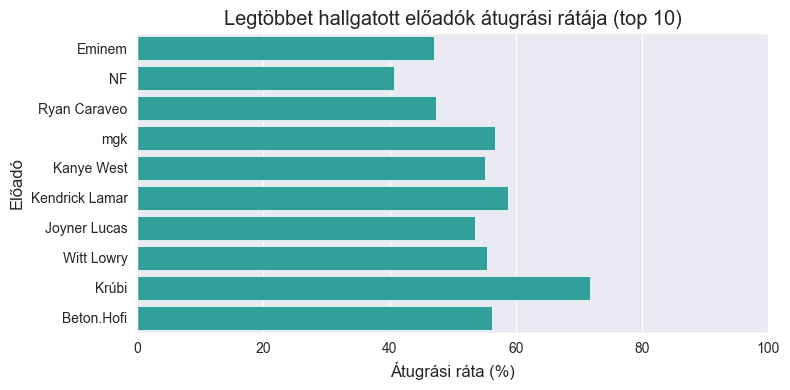

In [153]:
# Legtöbbet hallgatott előadók átugrási rátája (top 10)

top_listened = stats.sort_values('perc', ascending=False).head(10)  # Top 10 legtöbbet hallgatott előadó
print('Legtöbbet hallgatott előadók átugrási rátája (top 10):')
display(
    top_listened[['artist','minta','kihagyas','Átugrási ráta (%)','perc']]
         .round({'Átugrási ráta (%)':2, 'perc':1})  # Kerekítés
)


# diagram – legtöbbet hallgatott 10
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=top_listened, x='Átugrási ráta (%)', y='artist', color='lightseagreen')  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Legtöbbet hallgatott előadók átugrási rátája (top 10)')  # Cím
plt.xlabel('Átugrási ráta (%)')  # X tengely felirat
plt.ylabel('Előadó')  # Y tengely felirat
plt.xlim(0,100)  # X tengely 0..100%
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

In [154]:
# Legtöbbet hallgatott előadó és szám, egy szám összes hallgatott ideje – év/hónap kiválasztóval

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Elérhető év-hónap értékek kigyűjtése
available_months = sorted(df['month'].dropna().unique())

# Widget létrehozása
month_selector = widgets.Dropdown(
    options=available_months,
    value=available_months[-1],
    description='Hónap:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
 )

output = widgets.Output()

def update_top_tracks(change=None):
    with output:
        clear_output(wait=True)
        selected_month = month_selector.value
        # Top dalok: lejátszásszám és összes hallgatott idő (perc)
        top = (
            df[df['month'] == selected_month]
            .dropna(subset=['artist','track'])
            .groupby(['artist','track'])
            .agg(
                **{'Lejátszások száma': ('track', 'size'), 'Összes perc': ('min', 'sum')}
            )
            .reset_index()
            .sort_values('Lejátszások száma', ascending=False)
            .head(20)
        )
        print(f'Legtöbbet hallgatott előadó és szám {selected_month}-ban:')
        # Táblázat középre igazítása HTML-lel
        styled_html = top.to_html(index=False, justify='center', float_format=lambda x: f"{x:.1f}" if isinstance(x, float) else str(x))
        display(HTML(f'<div style="display: flex; justify-content: center; margin-bottom: 60px;">{styled_html}</div>'))

        
        plt.figure(figsize=(10,5))
        sns.barplot(data=top, x='Lejátszások száma', y='track', hue='artist', dodge=False)
        plt.title(f'Legtöbbet hallgatott előadó és szám {selected_month}-ban')
        plt.xlabel('Lejátszások száma')
        plt.ylabel('Dal')
        plt.legend(title='Előadó')
        plt.tight_layout()
        plt.show()

month_selector.observe(update_top_tracks, names='value')
display(month_selector)
display(output)
update_top_tracks()  # Első futtatás

Dropdown(description='Hónap:', index=62, layout=Layout(width='300px'), options=('2018-07', '2018-08', '2018-09…

Output()

In [156]:
# Egyszerű interaktív: adj meg egy előadót, majd OK → top 10 szám (összes perc)

# --- Könyvtárak importálása ---
import ipywidgets as widgets  # Interaktív widgetek (pl. szövegmező, gomb) notebookhoz
from IPython.display import display, clear_output  # Megjelenítés és kimenet törlése notebookban

# --- Felhasználói útmutató ---
print('Írj be egy előadó nevet, majd nyomj OK-t. (Nem case sensitive)')  # Felhasználói útmutató kiírása

# --- Szövegbeviteli mező létrehozása ---
artist_input = widgets.Text(  # Szövegbeviteli mező előadó nevéhez
    placeholder='Előadó neve',  # Segédszöveg a mezőben, amíg üres
    description='Előadó:',      # Címke a mező előtt
    style={'description_width': 'initial'},  # Címke szélességének beállítása
    layout=widgets.Layout(width='300px')     # Mező szélessége (300px)
)

# --- OK gomb létrehozása ---
ok_button = widgets.Button(  # OK gomb
    description='OK',            # Gomb felirata
    button_style='success',      # Zöld szín (success)
    layout=widgets.Layout(width='80px', height='32px')  # Gomb mérete
)

# --- Kimeneti terület ---
output_artist = widgets.Output()  # Ide kerül a lekérdezés eredménye

# --- Eseménykezelő függvény ---
def on_ok_clicked(b=None):
    # Minden kimenet az output_artist területre kerül
    with output_artist:
        # Előző eredmények törlése, hogy mindig csak az aktuális látszódjon
        clear_output(wait=True)

        # A szövegmezőből kiolvasott előadónév, szóközök levágva
        name = artist_input.value.strip()

        # Ha üres a mező
        if not name:
            print('Írj be egy előadó nevet, majd nyomj OK-t.')  # Hibaüzenet, ha nincs név
            return  # Kilépés a függvényből

        # Logikai maszk: az artist oszlopban kisbetűs egyezés a beírt névvel (NaN helyett üres string)
        mask = df['artist'].fillna('').str.lower() == name.lower()

        # Csak azok a sorok, ahol az előadó egyezik
        sub = df[mask]

        # Ha nincs találat
        if sub.empty:
            print(f'Nincs találat: {name}')  # Hibaüzenet, ha nincs ilyen előadó
            return  # Kilépés a függvényből

        # Top 10 szám lekérdezése az adott előadótól
        top = (
            sub.dropna(subset=['track'])              # Először eldobja a hiányzó track nevű sorokat
            .groupby('track')['min'].sum()            # Track (dal) szerint csoportosít, és összeadja a perceket
            .reset_index(name='Összes perc')          # Új index, a track marad oszlopként, az összegzett perc új oszlopnév
            .sort_values('Összes perc', ascending=False)  # Csökkenő sorrendbe rakja az összes perc alapján
            .head(10)                                 # Csak a legelső 10 sort tartja meg (top 10 dal)
        )

        # Eredmény címének kiírása
        print(f'Top 10 szám {name} előadótól (összes perc):')

        # Táblázat megjelenítése, az összes perc 1 tizedesre kerekítve
        display(top.round({'Összes perc': 1}))

        # Új ábra létrehozása, méret: 8x4 inch
        plt.figure(figsize=(8,4))

        # Vízszintes oszlopdiagram: x az összes perc, y a dal neve, szín: lila
        sns.barplot(data=top, x='Összes perc', y='track', color='purple')

        # Diagram címe
        plt.title(f'Top 10 {name} szám (összes perc)')

        # X tengely felirat
        plt.xlabel('Összes perc')

        # Y tengely felirat
        plt.ylabel('Dal')

        # Elrendezés optimalizálása, hogy ne lógjon ki semmi
        plt.tight_layout()

        # Diagram megjelenítése notebookban
        plt.show()

# --- Az OK gombhoz hozzárendeli az eseménykezelő függvényt ---
ok_button.on_click(on_ok_clicked)

# --- A szövegmező és gomb egymás mellett jelenik meg ---
display(widgets.HBox([artist_input, ok_button]))

# --- Az eredményterület megjelenítése a cella végén ---
display(output_artist)


Írj be egy előadó nevet, majd nyomj OK-t. (Nem case sensitive)


Output()

In [ ]:
# Hány dalt hallgattam meg összesen, ismétlésekkel, tehát az összes valaha lejátszott dalt számolva

total_tracks_count = df.dropna(subset=['artist', 'track']).shape[0]  # Összes lejátszott dal száma
print(f'Összesen {total_tracks_count:,} dalt hallgattam meg.')  # Eredmény kiírása formázva



Összesen 134,235 dalt hallgattam meg.


Összesen 8,203 egyedi dalt hallgattam meg.


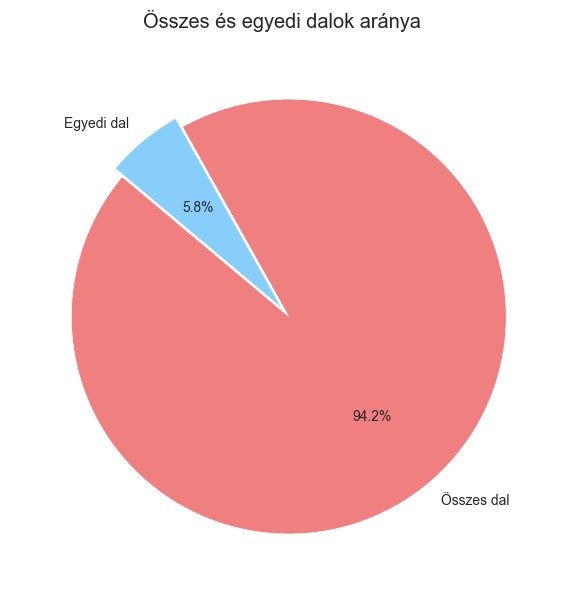

In [161]:
# Hány unique dalt hallgattál meg összesen, ismétlések nélkül, tehát csak az egyedi előadó-dal párosokat számolva
unique_tracks_count = df.dropna(subset=['artist', 'track']).drop_duplicates(subset=['artist', 'track']).shape[0]  # Egyedi dalok száma
print(f'Összesen {unique_tracks_count:,} egyedi dalt hallgattam meg.')  # Eredmény kiírása formázva


#diagram
labels = ['Összes dal', 'Egyedi dal']  # Kördiagram szeleteinek címkéi
sizes = [total_tracks_count, unique_tracks_count]  # Kördiagram szeleteinek méretei
colors = ['lightcoral', 'lightskyblue']  # Kördiagram szeleteinek színei    
explode = (0.05, 0)  # Az első szelet kiemelése
plt.figure(figsize=(6,6))  # Ábra létrehozása adott méretben
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)  # Kördiagram
plt.title('Összes és egyedi dalok aránya')  # Cím
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése

Top 10 dal a leghosszabb egyhuzamos lejátszási idő alapján (másodperc):


,artist,track,Leghosszabb egyhuzamos lejátszás (sec)
1902,Drake,Family Matters,3603.1
4025,Kendrick Lamar,"Sing About Me, I'm Dying Of Thirst",1718.4
1735,Dax,The Next Rap God 2,1697.4
5881,Powfu,"death bed, Pt. 2",1407.2
7520,Witt Lowry,Wonder If You Wonder,1333.3
2440,Eminem,Tobey (feat. Big Sean and BabyTron),1242.0
172,AJR,Turning Out Pt. ii,1233.0
3077,J. Cole,4 Your Eyez Only,1144.2
3618,Joyner Lucas,Tear Me Down,1130.4
2278,Eminem,Drug Ballad,1126.1


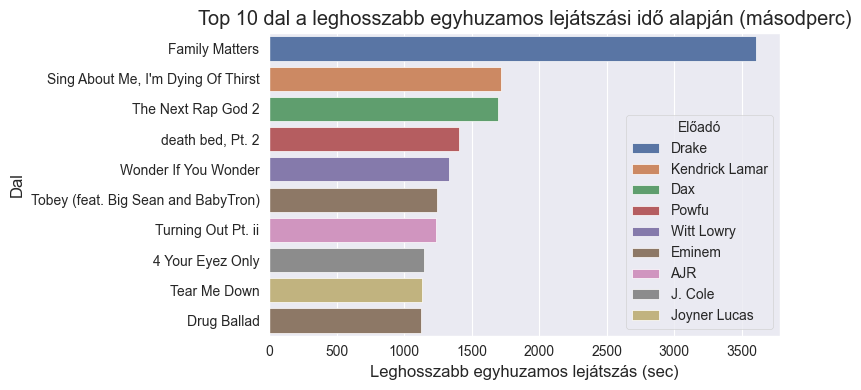

In [158]:
# Melyik dalokat hallgattad meg a leghosszabb ideig egyhuzamban?

longest_sessions = (
    df.dropna(subset=['artist', 'track'])  # Hiányzó előadó/dal eldobása
    .sort_values('ts')  # Időrendi sorrend
    .groupby(['artist', 'track'])['sec']  # Előadó–dal páronként csoportosítás
    .max()  # Maximális egyhuzamos lejátszási idő (másodperc)
    .reset_index(name='Leghosszabb egyhuzamos lejátszás (sec)')  # Táblává alakítás és oszlopnév
    .sort_values('Leghosszabb egyhuzamos lejátszás (sec)', ascending=False)  # Csökkenő sorrend
    .head(10)  # Top 10 dal
)

print('Top 10 dal a leghosszabb egyhuzamos lejátszási idő alapján (másodperc):')
display(longest_sessions.round({'Leghosszabb egyhuzamos lejátszás (sec)': 1}))  # Kerekítés 1 tizedesre

# Diagram készítése a leghosszabb egyhuzamos lejátszási idő alapján
plt.figure(figsize=(8,4))  # Ábra létrehozása adott méretben
sns.barplot(data=longest_sessions, x='Leghosszabb egyhuzamos lejátszás (sec)', y='track', hue='artist', dodge=False)  # Vízszintes oszlopdiagram Seaborn-nal
plt.title('Top 10 dal a leghosszabb egyhuzamos lejátszási idő alapján (másodperc)')  # Cím
plt.xlabel('Leghosszabb egyhuzamos lejátszás (sec)')  # X tengely felirat
plt.ylabel('Dal')  # Y tengely felirat  
plt.legend(title='Előadó')  # Jelmagyarázat címmel
plt.tight_layout()  # Elrendezés optimalizálása
plt.show()  # Ábra megjelenítése